# Deep Learning 2023 - Assignment 2: Neural Networks
Designed by Haotian Liu (haotian.liu@oulu.fi)

## Outline 
#### In this assignment, you will learn:
* Neural Network, Deep Neural Network, Loss Function and Optimization.
* Building a simple NN using numpy to understand the backpropagation.
* Gradient check using finite-difference approximation.
* Stochastic Gradient Descent (SGD).
* Regularization and simple hype-parameters tuning methods to improve your NN performance.

#### Grading (<span style="color:green">15 points</span>)

* **Part 1. Import Libraries, Loading and Preprocessing the Training and Testing Data.**
* **Part 2. Build the Neural Network, Forward and Backward Propagation. (<span style="color:green">9.5 points</span>)**
  * 2.1 Check the structure of data samples (<span style="color:green">0.5 points</span>)
    * Question (<span style="color:green">0.5 points</span>)
  * 2.2 Construct the model and implement the forward propagation (<span style="color:green">5 points</span>)
    * Initialize the model parameters (<span style="color:green">1 points</span>)
    * Define the activation function (<span style="color:green">3 points</span>)
    * Construct the forward propagation function (<span style="color:green">1 points</span>)
  * 2.3 Loss function computation and backward propagation (<span style="color:green">4 points</span>)
    * Implement the loss function (<span style="color:green">1 points</span>)
    * Implement the backward propagation (<span style="color:green">3 points</span>)
    * Extended Reading: Gradient check using finite-difference approximation.
* **Part 3. Training and Evaluation of Neural Network (<span style="color:green">2.5 points</span>)**
  * 3.1 Training your network (<span style="color:green">2 points</span>)
  * 3.2 Evaluate the performance of your model (<span style="color:green">0.5 points</span>)

* **Part 4. Regularization and Hyperparameter Tuning (<span style="color:green">3 points</span>)**
  * 4.1 Implement weight decay loss and backward propagation  (<span style="color:green">2 points</span>)
  * 4.2 Hyperparameter Tuning (<span style="color:green">1 points</span>)

#### Environment
Python 3, Numpy, matplotlib, sklearn

#### Dataset
* [**Fashion-MNIST**](https://github.com/zalandoresearch/fashion-mnist)
is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. Using the Fashion-MNIST give you more room to wiggle your experiments.

#### Hints
* To find the place where you have to insert your solution, hit Crtl + F and search for **TODO:** . You are NOT suppose to modify the codes from other parts.
* **Be careful with the shape** of the weights, gradient, .. of your tensor in your implementation. Double check and make sure the shapes are fit for computation, especially matrix multiplication.
* You could check the correctness of your code by comparing the intermediate outputs with the **<span style="color:green">Reference Results</span>**. **Remember to do this step by step to avoid getting lost.**

## Part 1. Import Libraries, Loading and Preprocessing the Training and Testing Data
**You don't need to change the code from this part.**

In [1]:
# You will mainly use numpy to construct your NN
import numpy as np
import matplotlib, time, copy, os, requests, zipfile, sys
# Matplotlib to plot the image
import matplotlib.pyplot as plt
# Off-the-shelf evaluation functions provided by sklearn
from sklearn.metrics import confusion_matrix, accuracy_score

### Functions use to download the dataset from OneDrive
Here we use the [onedrivedownloader](https://pypi.org/project/onedrivedownloader/) package for data download.

In [2]:
!pip install onedrivedownloader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.3 MB/s eta 0:00:00


In [2]:
from onedrivedownloader import download

link = 'https://unioulu-my.sharepoint.com/:u:/g/personal/hliu22_univ_yo_oulu_fi/EW3HQP_PhE9GpXBS50bADNIBzmmQX2lBpaEp-9mWhpPrsA?e=auRurQ'

if not os.path.exists('./data_hw2/fashion_mnist_npy'):
    print('Downloading dataset')
    download(link, filename="./fashion_mnist_npy.zip", unzip=True, unzip_path='./data_hw2/fashion_mnist_npy')

### Functions use to pre-process your training/testing data

In [3]:
def reshape_train_data(X):
    ''' Input training data has shape (60000, 28, 28)
        Input testing data has shape (10000, 28, 28)
        where: 
        60000 is the numbers of input training samples
        10000 is the numbers of input testing samples
        similar to MNIST, resolution of each sample is 28 x 28
    '''
    samples, H, W = X.shape
    # Reshape input volume to (sample, 784), this mean, your NN input layer will have 784 placeholders
    # we scale the RGB values by divide them by 255, this will help improve the training performance
    return X.reshape(samples, H * W).T / 255

def one_hot_vector(x, num_classes):
    # By now, I think you already heard about this so many times
    return np.eye(num_classes)[x].T

### Finally, we load and preprocess the data

[9 0 0 ... 3 0 5]
(10, 60000)


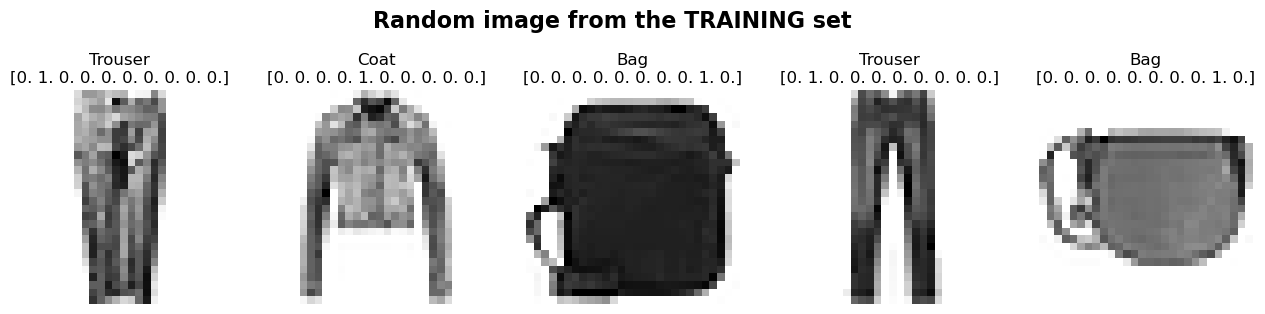

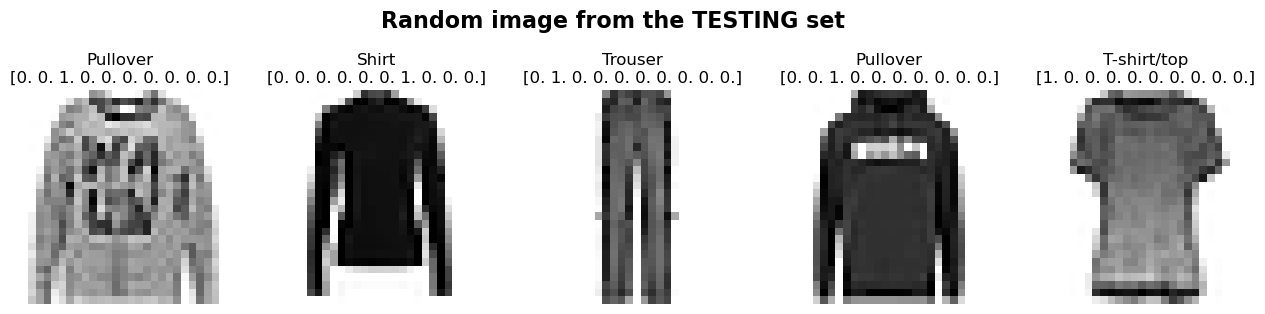

In [4]:
PATH = os.path.join('data_hw2', 'fashion_mnist_npy')

# The actual meaning of the label of your classes.
# E.g. if an output one-hot vector is [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], it used to prepresent a Dress
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Load the training input
X_train = np.load(os.path.join(PATH, 'train_data.npy'))
# Load the training labels
X_test = np.load(os.path.join(PATH, 'test_data.npy'))
# Load the testing input
Y_train = np.load(os.path.join(PATH, 'train_labels.npy'))
# Load the testing labels
Y_test = np.load(os.path.join(PATH, 'test_labels.npy'))

# Get the number of classes
num_classes = len(label_names)
# Get the number of training samples and their resolution for reshape
num_trains, HEIGHT, WIDTH = X_train.shape

# Reshape the training and testing inputs
X_train, X_test = reshape_train_data(X_train), reshape_train_data(X_test)

# Create one-hot vector for the training and testing labels
np.set_printoptions()
print(Y_train)
Y_train, Y_test = one_hot_vector(Y_train, num_classes), one_hot_vector(Y_test, num_classes)
print(Y_train.shape)
# This part use to randomly load some of the training and testing image and the one-hot vectors for checking
fig_train, ax_train = plt.subplots(figsize=(16, 8), nrows=1, ncols=5)
fig_train.suptitle("Random image from the TRAINING set", y=0.73, fontsize=16, fontweight='bold')

fig_test, ax_test = plt.subplots(figsize=(16, 8), nrows=1, ncols=5)
fig_test.suptitle("Random image from the TESTING set", y=0.73, fontsize=16, fontweight='bold')

for idx in range(5):
    i, j = np.random.randint(num_trains), np.random.randint(X_test.shape[0])
    
    ax_train[idx].imshow(X_train[:,i].reshape(HEIGHT, WIDTH), cmap = matplotlib.cm.binary)
    ax_train[idx].set_title(label_names[np.argmax(Y_train[:,i])] + "\n" + str(Y_train[:,i]))
    ax_train[idx].axis('off')
    
    ax_test[idx].imshow(X_test[:,j].reshape(HEIGHT, WIDTH), cmap = matplotlib.cm.binary)
    ax_test[idx].set_title(label_names[np.argmax(Y_test[:,j])] + "\n" + str(Y_test[:,j]))
    ax_test[idx].axis('off')

## Part 2. Build the Neural Network, Forward and Backward Propagation (<span style="color:green">9.5 points</span>)
#### The fun part start from here.
*Definition:* loss function is a function that maps an event or values of one or more variables onto a real number intuitively representing some "cost" associated with the event. Loss function (sometimes called cost function) is used to calculate the gradient by applying the chain rule, so that we can update the weights (and bias) of our neural network using an optimizer such as gradient descent. <br>
It could be interpreted as using the loss function to calculate the network’s layers error, in which we calculate the error of the current layer, then pass the weighted error back to the previous layer, and recursively doing this until we travel back to the first hidden layer. At each layer, we update the weights using the derivative of the cost for each weight.

Let illustrate this concept using a simple toy example.



![Figure1.png](http://yty.kapsi.fi/DLcourse/ass1/Figure1.png)

<center> <strong> <font size="3" color="blue"> Figure 1. Toy example of backpropagation </font> </strong> </center>

In **Fig. 1** we have a loss function $L$:
\begin{align}
L = c \times d
\end{align}

where <br>

\begin{align}
c = a + b -5
\end{align}

and, <br>

\begin{align}
d = b^2 + b -1
\end{align}

As illustrated in **Fig. 1**, the equations in the edge show the partial derivation of some functions with respect to their direct variables. For example, $\frac{\partial L}{\partial c}$ is the partial derivative of $L$ with respect to $c$. <br>
However, we are actually interested in calculating the derivative of $L$ with respect to $a$ and $b$, which don't directly connected with each other. So, how can we do this? As mentioned earlier, we can do this using the chain-rule so that we can calculate $\frac{\partial L}{\partial a}$ and $\frac{\partial L}{\partial b}$ as:

\begin{align}
\frac{\partial L}{\partial a} = \frac{\partial L}{\partial c} \cdot \frac{\partial c}{\partial a}
\end{align}

and, <br>

\begin{align}
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial c} \cdot \frac{\partial c}{\partial b} + \frac{\partial L}{\partial d} \cdot \frac{\partial d}{\partial b}
\end{align}

More importantly, **we can see that $a$ affect $L$ through $c$, and so on**. This concept hold no matter how many hidden layers you have or how complicated your loss will be as long as you use backpropagation to calculate the derivative to update your weights.

**Now, let's get your hand dirty.**

### 2.1 Check the structure of data samples (<span style="color:green">0.5 points</span>)

Before we start, one important thing is to check the structure of data samples. We can run the following code to print the shape of traing and testing data.

In [6]:
print('Shape of X_train:', X_train.shape)
print('Shape of Y_train:', Y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of Y_test:', Y_test.shape)

Shape of X_train: (784, 60000)
Shape of Y_train: (10, 60000)
Shape of X_test: (784, 10000)
Shape of Y_test: (10, 10000)


### Question: For the training data, X_train has a shape of (784, 60000), while Y_train has a shape of (10, 60000). What do the numbers refer to? What is 784, what is 10 and what is 60000? (<span style="color:green">0.5 points</span>)

**Answer (TODO):**

X_train has 28x28 with 60000 samples. Each of these 28x28 matrices have been straightened to by concatenating columns making a single column vector of size 784x1. This number 784 is derived by counting all of the pixel values in the X_train samples.

Similarly X_test also has 28x28 sized samples. But only 10000 Samples are there. That makes the size of X_test (784,10000)

On the other hand, Y_train has 10 class labels for each of the 60000 samples. Which makes the shape of it (10,6000).
 Similarly Y_test has 10 class labels mapping each of the 10000 samples. Which makes (10,10000)
 

### 2.2 Construct the model and implement the forward propagation (<span style="color:green">5 points</span>)

Let's take a look at the model in **Fig. 2** below. This is the model we are gonna use in this assignment.



![Figure2.png](http://yty.kapsi.fi/DLcourse/ass1/Figure2.png)

<center> <strong> <font size="4" color="blue"> Figure 2. Structure of our neural network </font> </strong> </center>

### Initialize the model parameters (<span style="color:green">1 points</span>)

As shown in the **Fig. 2**, our neural network contains two hidden layers (we use **9** and **3** neurons as the  first hidden layer and the second hidden layer default setting respectively) and an output layer. To further simplify things, we will not include biases in our model. Be aware that, while the number of neurons in the hidden layer can be arbitrary, there must be 10 neurons in the output layer because we want our model to classify images from 10 classes. Based on the **Fig. 2**, you have to construct your network. 

Note that to make the computation implementation more friendly, we will define the network parameters with shape **(out_dim, in_dim)**.

In [5]:
# Numbers of input units
num_inputs = X_train.shape[0]

# Number of neural in your hidden layer
num_hidden_1 = 9
num_hidden_2 = 3

# Numbers of output units
num_outputs = num_classes

In [6]:
def init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs):
    """Method for initialize the model parameters and the learning velocity of momentum for SGD.

    Returns:
        parameters (tuple): The model parameters: W1, W2, W3
        velocity (tuple): The learning velocity of momentum: V_dW1, V_dW2, V_dW3
    """

    # Construct your neural network in Fig. 2 
    # TODO: Random initialize the hidden_1, hidden_2 and output layer weights (w/o bias) (1 point)
    # Hints: use np.random.randn()
    W1 = np.random.randn(num_hidden_1, num_inputs)
    W2 = np.random.randn(num_hidden_2, num_hidden_1)
    W3 = np.random.randn(num_outputs, num_hidden_2)

    parameters = W1, W2, W3

    # Zeros initialize the momentum for SGD
    V_dW1 = np.zeros(W1.shape)
    V_dW2 = np.zeros(W2.shape)
    V_dW3 = np.zeros(W3.shape)

    velocity = V_dW1, V_dW2, V_dW3

    return parameters, velocity

In [8]:
parameters, velocity = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)

W1, W2, W3 = parameters

print('Shape of W1:', W1.shape)
print('Shape of W2:', W2.shape)
print('Shape of W3:', W3.shape)

Shape of W1: (9, 784)
Shape of W2: (3, 9)
Shape of W3: (10, 3)


**<span style="color:green">Reference Results:</span>** <br>
Shape of W1: (9, 784)<br>
Shape of W2: (3, 9)<br>
Shape of W3: (10, 3)<br>

### Define the activation function (<span style="color:green">3 points</span>)

The sigmoid activation is defined as:

$$
{\rm sigmoid}(x) = \frac{1}{1 + e^{-x}}
\tag{1}
$$

The ReLU (Rectified Linear Unit) is defined as:

$$
{\rm ReLU}(x) = \text{max}(x, 0) =
\begin{cases}
x, & \text{if}\ x > 0 \\
0, & \text{otherwise}
\end{cases}
\tag{2}
$$


The softmax activation is defined as:

$$
{\rm softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^{N}e^{x_j}}\ \text{for}\ i\ \text{in}\ \left\{1,...,N \right\}
\tag{3}
$$

where $N$ is the number of classes.

In [15]:
def sigmoid(X):
    # TODO: implement Eq. 1 (1 point)
    # Hints: use np.exp()
    return 1 / (1 + np.exp(-X))

def relu(X):
    # TODO: implement Eq. 2 (1 point)
    # Hints: use np.maximum()
    return np.maximum(0, X)

def softmax(X):
    # TODO: implement Eq. 3 (1 point)
    # Hints: use np.exp() and np.sum(, axis=0) <- beware of the axis
    return np.exp(X) / np.sum(np.exp(X), axis=0)

In [16]:
X = np.array([-1, 0, 2]).reshape(-1, 1)

print('X')
print(X, '\n')

print('sigmoid(x)')
print(sigmoid(X), '\n')

print('relu(x)')
print(relu(X), '\n')

print('softmax(x)')
print(softmax(X))

X
[[-1]
 [ 0]
 [ 2]] 

sigmoid(x)
[[0.26894142]
 [0.5       ]
 [0.88079708]] 

relu(x)
[[0]
 [0]
 [2]] 

softmax(x)
[[0.04201007]
 [0.1141952 ]
 [0.84379473]]


**<span style="color:green">Reference Results:</span>** <br>
sigmoid(x)<br>
[[0.26894142]<br>
 [0.5       ]<br>
 [0.88079708]]<br>

relu(x)<br>
[[0]<br>
 [0]<br>
 [2]]<br> 

softmax(x)<br>
[[0.04201007]<br>
 [0.1141952 ]<br>
 [0.84379473]]<br>

To get a better understanding of the activation functions sigmoid and ReLU, we can also visualize them as follows:

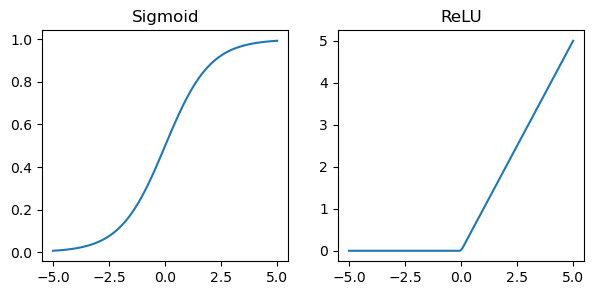

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

x = np.linspace(-5, 5, 100).reshape(-1, 1)

ax[0].set_title('Sigmoid')
ax[0].plot(x, sigmoid(x))

ax[1].set_title('ReLU')
ax[1].plot(x, relu(x))

### Construct the forward propagation function (<span style="color:green">1 points</span>)

According to the model in **Fig. 2**, our **forward-propagation** consists of three parts:

First, we to start with the calculation of the output volume $A_1$ for the first hidden layer:

$$
\begin{align}
Z_1 &= W_1 X \tag{4} \\
A_1 &= {\rm sigmoid}(Z_1) \tag{5}
\end{align}
$$

where $W_1$ is the weights of the first hidden layer, $X$ is the input, and here we use the **sigmoid** activation.


Then, we calculate the hidden volume of the second hidden layer $A_2$ by:

$$
\begin{align}
Z_2 &= W_2 A_1 \tag{6} \\
A_2 &= {\rm ReLU}(Z_2) \tag{7}
\end{align}
$$

where $W_2$ is the weights of the second hidden layer, and here we use the **ReLU** activation.

Finally, we calculate the output volume of the output layer $A_3$ by:

$$
\begin{align}
Z_3 &= W_3 A_2 \tag{8} \\
A_3 &= {\rm softmax}(Z_3) \tag{9}
\end{align}
$$

where $W_3$ is the weights of the output layer, and here we use the softmax activation.

In this way, we get the final classification predction outputs $A_3$ from the last hidden layer.

In [18]:
def forward_propagation(X, parameters):
    """Method for forward propagation.
    Args:
        X (np.array): Input data
        parameters (tuple): Parameters in the model: W1, W2, W3

    Returns:
        outputs (tuple): The forward propagation outputs: Z1, A1, Z2, A2, Z3, A3
    """

    W1, W2, W3 = parameters
    
    # TODO: implement the forward propagation of Fig. 2 based on Eq. 4 - 9 (1 point)
    # Hints: use np.matmul() to implement matrix multiplication
    
    Z1 = np.matmul(W1, X)
    A1 = sigmoid(Z1)
    Z2 = np.matmul(W2, A1)
    A2 = relu(Z2)
    Z3 = np.matmul(W3, A2)
    A3 = softmax(Z3)
    outputs = Z1, A1, Z2, A2, Z3, A3
    return outputs

In [19]:
np.random.seed(1)
X = np.random.randn(num_inputs, 2)

parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)
Z1, A1, Z2, A2, Z3, A3 = forward_propagation(X, parameters)

print('Shape of X:', X.shape)
print('Shape of Z1:', Z1.shape)
print('Shape of A1:', A1.shape)
print('Shape of Z2:', Z2.shape)
print('Shape of A2:', A2.shape)
print('Shape of Z3:', Z3.shape)
print('Shape of A3:', A3.shape)

print('\nExample results of A3:')
print(A3)

Shape of X: (784, 2)
Shape of Z1: (9, 2)
Shape of A1: (9, 2)
Shape of Z2: (3, 2)
Shape of A2: (3, 2)
Shape of Z3: (10, 2)
Shape of A3: (10, 2)

Example results of A3:
[[2.46725014e-03 9.30825544e-07]
 [3.31005452e-04 6.34655955e-07]
 [5.99451371e-01 9.95638430e-01]
 [9.09817956e-03 4.04817220e-03]
 [1.65653873e-01 4.63410273e-05]
 [3.01971551e-03 8.33547818e-07]
 [1.36952654e-01 3.46917061e-05]
 [6.84035576e-04 1.15346167e-05]
 [8.23364875e-02 2.18431338e-04]
 [5.42874551e-06 6.05182642e-11]]


**<span style="color:green">Reference Results:</span>** <br>
Shape of X: (784, 2)<br>
Shape of Z1: (9, 2)<br>
Shape of A1: (9, 2)<br>
Shape of Z2: (3, 2)<br>
Shape of A2: (3, 2)<br>
Shape of Z3: (10, 2)<br>
Shape of A3: (10, 2)<br>

Example results of A3:<br>
[[2.46725014e-03 9.30825544e-07]<br>
 [3.31005452e-04 6.34655955e-07]<br>
 [5.99451371e-01 9.95638430e-01]<br>
 [9.09817956e-03 4.04817220e-03]<br>
 [1.65653873e-01 4.63410273e-05]<br>
 [3.01971551e-03 8.33547818e-07]<br>
 [1.36952654e-01 3.46917061e-05]<br>
 [6.84035576e-04 1.15346167e-05]<br>
 [8.23364875e-02 2.18431338e-04]<br>
 [5.42874551e-06 6.05182642e-11]]<br>

### 2.3 Loss function computation and backward propagation (<span style="color:green">4 points</span>)

### Implement the loss function (<span style="color:green">1 points</span>)

Here we calculate the cross entropy loss function by:

$$
L = {\rm cross\_entropy}(Y, A_3) = - \frac{1}{M} \sum_{k=0}^{M} \sum_{i=0}^{N} Y_i^{k} log({A_3}_i^{k}) \tag{10}
$$

where $Y$ is the ground truth labels, $A_3$ is the prediction outputs, $N$ is the number of classes, $M$ is the number of samples in the training batch.

In [20]:
def cross_entropy_loss(Y, Y_pred):
    # TODO: implement Eq. 10 (1 point)
    # Hints: use np.sum(), np.multiply() and np.log()
    # At the end, we need to divide by the number of of sample in the training batch e.g. m = Y.shape[1]
    m = Y.shape[1]
    ceLoss = - np.sum(np.multiply(Y, np.log(Y_pred))) / m
    return ceLoss

In [21]:
np.random.seed(1)
Y = one_hot_vector(np.random.randint(1, num_classes, 2), num_classes)
A3 = softmax(np.random.randn(num_classes, 2))

L = cross_entropy_loss(Y, A3)
print('Shape of Y:', Y.shape)
print('Shape of A3:', A3.shape)
print('Loss:', L)

Shape of Y: (10, 2)
Shape of A3: (10, 2)
Loss: 1.4200061694735258


**<span style="color:green">Reference Results:</span>** <br>
Shape of Y: (10, 2)<br>
Shape of A3: (10, 2)<br>
Loss: 1.4200061694735258<br>

### Implement the backward propagation (<span style="color:green">3 points</span>)

Using what you learnt in undergraduate school, let's calculate the **backward-propagation** for our model in **Fig. 2**. <br>

As mentioned earlier, we are interested in $\frac{\partial L}{\partial W_1}$, $\frac{\partial L}{\partial W_2}$ and $\frac{\partial L}{\partial W_3}$, where: 

$$
\frac{\partial L}{\partial W_3} = \frac{\partial L}{\partial A_3} \cdot \frac{\partial A_3}{\partial Z_3} \cdot \frac{\partial Z_3}{\partial W_3} \tag{11}
$$

,

$$
\frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial A_3} \cdot \frac{\partial A_3}{\partial Z_3} \cdot \frac{\partial Z_3}{\partial A_2} \cdot \frac{\partial A_2}{\partial Z_2} \cdot \frac{\partial Z_2}{\partial W_2} \tag{12}
$$

and, 

$$
\frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial A_3} \cdot \frac{\partial A_3}{\partial Z_3} \cdot \frac{\partial Z_3}{\partial A_2} \cdot \frac{\partial A_2}{\partial Z_2} \cdot \frac{\partial Z_2} {\partial A_1} \cdot \frac{\partial A_1}{\partial Z_1} \cdot \frac{\partial Z_1}{\partial W_1} \tag{13}
$$

From **Eq. 11** we have:

The derivative of $L$ with respect to $Z_3$:

$$
dZ_3 = \frac{\partial L}{\partial Z_3} = \frac{\partial L}{\partial A_3} \cdot \frac{\partial A_3}{\partial Z_3} = A_3 - Y \tag{14}
$$

<br>

The derivative of $L$ with respect to $W_3$:

$$
d W_3 = \frac{\partial L}{\partial W_3} = \frac{\partial L}{\partial Z_3} \cdot \frac{\partial Z_3}{\partial W_3} = \frac{1}{m} d Z_3 \cdot A_2^T \tag{15}
$$

Here $m$ is the number of data samples in a mini batch.

<br>


From **Eq. 12** we have:

The derivative of $L$ with respect to $A_2$:
$$
d A_2 = \frac{\partial L}{\partial A_2} = \frac{\partial L}{\partial Z_3} \cdot \frac{\partial Z_3}{\partial A_2} = W_3^T \cdot (A_3 - Y) \tag{16}
$$

The derivative of $L$ with respect to $Z_2$: 
$$
\frac{\partial A_2}{\partial Z_2} = {\rm int}(A2 > 0) \tag{17}
$$

$$
d Z_2 = \frac{\partial L}{\partial Z_2} = \frac{\partial L}{\partial A_2} \cdot \frac{\partial A_2}{\partial Z_2} = d A_2 * {\rm int}(A2 > 0) \tag{18}
$$

The derivative of $L$ with respect to $W_2$: 
$$
d W_2 = \frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial Z_2} \cdot \frac{\partial Z_2}{\partial W_2} = \frac{1}{m} d Z_2 \cdot A_1^T \tag{19}
$$

<br>


From **Eq. 13** we have:

The derivative of $L$ with respect to $A_1$:
$$
d A_1 = \frac{\partial L}{\partial A_1} = \frac{\partial L}{\partial Z_2} \cdot \frac{\partial Z_2}{\partial A_1} = W_2^T \cdot d Z_2\tag{20}
$$

The derivative of $L$ with respect to $Z_1$: 
$$
\frac{\partial A_1}{\partial Z_1} = A1 * (1 - A1) \tag{21}
$$

$$
d Z_1 = \frac{\partial L}{\partial Z_1} = \frac{\partial L}{\partial A_1} \cdot \frac{\partial A_1}{\partial Z_1} = d A_1 * A1 * (1 - A1) \tag{22}
$$

The derivative of $L$ with respect to $W_1$: 
$$
d W_1 = \frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial Z_1} \cdot \frac{\partial Z_1}{\partial W_1} = \frac{1}{m} d Z_1 \cdot X^T \tag{23}
$$

<br>


**Hints**

For the above equations:
- $A \cdot B$ denotes the matrix multiplication between matrix $A$ and $B$, it can be implementated by using `np.matmul(A, B)`. 
- $A * B$ denotes the [Hadamard product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) (element-wise product) between $A$ and $B$, which can be implemented by using `np.multiply(A, B)` or `A * B`.
- $A^T$ denotes the [Transpose](https://en.wikipedia.org/wiki/Transpose) of matrix $A$, which can be implemented by using `A.T`
- ${\rm int}(A)$ denotes an operation that converts a matrix of type boolean to type integer, which can be implemented by using `A.astype(int)`.
- $m$ is the number of data samples in a mini batch.

In [30]:
def backward_propagation(X, Y, parameters, outputs):
    """Method for forward propagation.
    Args:
        X (np.array): Input data
        Y (np.array): Ground truth of input data
        parameters (tuple): Parameters in the model: W1, W2, W3
        outputs (tuple): The forward propagation outputs: Z1, A1, Z2, A2, Z3, A3
        
    Returns:
        tuple: The computed gradients: dW1, dW2, dW3     
    """

    m = X.shape[1] # The number of data samples in a mini batch

    W1, W2, W3 = parameters
    Z1, A1, Z2, A2, Z3, A3 = outputs
    
    # TODO: calculate the derivative of L with respect to Z3 and W3 using Eq. 14 - 15 (1 point)
    dZ3 = A3-Y
    dW3 = (1/m)*np.matmul(dZ3, A2.T)

    # TODO: calculate the derivative of L with respect to A2, Z2 and W2 using Eq. 16 - 19 (1 point)
    dA2 = np.matmul(W3.T, (A3-Y))
    AgtZero = A2>0
    dZ2 = dA2*AgtZero.astype(int)
    dW2 = (1/m)*np.matmul(dZ2, A1.T)

    # TODO: calculate the derivative of L with respect to A1, Z1 and W1 using Eq. 20 - 23 (1 point)
    dA1 = np.matmul(W2.T, dZ2)
    dZ1 = dA1*A1*(1-A1)
    dW1 = (1/m)*np.matmul(dZ1, X.T)

    return dW1, dW2, dW3

In [31]:
np.random.seed(1)
X = np.random.randn(num_inputs, 2)
Y = np.random.randint(1, num_classes, (2, ))

parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)
outputs = forward_propagation(X, parameters)
dW1, dW2, dW3 = backward_propagation(X, Y, parameters, outputs)

print('Shape of dW3:', dW3.shape)
print('Shape of dW2:', dW2.shape)
print('Shape of dW1:', dW1.shape)

print('\nExample results in dW3:')
print(dW3[:, 0])

print('\nExample results in dW2:')
print(dW2[:, 0])

print('\nExample results in dW1:')
print(dW1[:, 0])

Shape of dW3: (10, 3)
Shape of dW2: (3, 9)
Shape of dW1: (9, 784)

Example results in dW3:
[-11.07686748 -11.18325156 -11.07948311 -11.15090766  -9.30689316
 -11.18940487 -11.18383374 -11.18882248 -10.89794772 -11.14887099]

Example results in dW2:
[ 9.68479859 -5.5846308   4.69322188]

Example results in dW1:
[ 1.41874064e-02 -6.39869875e-01  2.22768707e-09 -8.80866594e-07
  2.06468965e-07  6.32945305e-06 -4.88517422e-10  7.55225226e-11
  4.40379402e-03]


**<span style="color:green">Reference Results:</span>** <br>
Shape of dW3: (10, 3)<br>
Shape of dW2: (3, 9)<br>
Shape of dW1: (9, 784)<br>

Example results in dW3:<br>
[-11.07686748 -11.18325156 -11.07948311 -11.15090766  -9.30689316<br>
 -11.18940487 -11.18383374 -11.18882248 -10.89794772 -11.14887099]<br>

Example results in dW2:<br>
[ 9.68479859 -5.5846308   4.69322188]<br>

Example results in dW1:<br>
[ 1.41874064e-02 -6.39869875e-01  2.22768707e-09 -8.80866594e-07<br>
  2.06468965e-07  6.32945305e-06 -4.88517422e-10  7.55225226e-11<br>
  4.40379402e-03]<br>

### Extended Reading: Gradient check using finite-difference approximation.

When training deep neural network, there are many things that can go wrong. Until this point, you probably notice that we have been going on and on about the gradient. Why? Because the gradient is very important. Hence, you must make sure that the calculation of your gradient is correct. A correct gradient calculation won't promise your model will converge, but if the calculation was wrong your model will perform very weird. This type of error is hard to debug, so we better prevent it beforehand. <br> 
To perform the gradient check, we can calculate gradient using the [finite-difference approximation](https://en.wikipedia.org/wiki/Finite_difference) (FDA), and let's call the output of FDA numerical gradients. Then we compare the numerical gradients with the gradient we calculate from taking the derivative. If the differences between them are small enough, we can assume that the gradient was calculated correctly. <br>

You probably learned about FDA in your undergraduate, but to refresh your mind, let's have a simple example to see how FDA works. Assume that we have a function $f(x)$ which <br>

\begin{align}
f(x) = \frac{1}{3} x^3 - \frac{1}{2} x^2 + 1 \tag{24}
\end{align}

Then, the derivative $\Delta f$ will be: <br>
\begin{align}
\Delta f = x^2 - x \tag{25}
\end{align}

At $x=2.125$, using **Eq. 25** we have $\Delta f = 2.390625$

If we calculate the numerical gradient using FDA we have:
\begin{align}
\Delta_{num\_grad} f = \frac{f(x + \epsilon) - f(x - \epsilon)}{2 * \epsilon}  \tag{26}
\end{align}

where $\epsilon$ is a very small value (E.g. $\epsilon = 1e-{04}$)

At the same point $x=2.125$, using **Eq. 20** we have $\Delta_{num\_grad} f = 2.3906250033389753$ <br>

We can see that, the calculated values of $\Delta f$ and $\Delta_{num\_grad} f$ are very close to each other. <br>

With the same idea, we can check the gradient calculation of our network using FDA. A simple way to do this is: <br>
1) We wiggle (by a very small $\epsilon$ values) the value of our weight for all of the parameters in our model. By all parameters, I mean all of the weights of $W_1$, $W_2$ and $W_3$. E.g. if we use 7 neurons in the first hidden layer and 3 neurons in the second hidden layer, the number of parameters in our network is : <br> 
$num\_params(net) = num\_params(W_1) + num\_params(W_2) + num\_params(W_3) = 28*28*7 + 7*7*3 + 3*10 = 5665$ <br>
so we have to repeat the "wiggling" and calculate the numerical gradient 5665 times. At the end, we have a $num\_grad$ vector that have shape (5665,) <br>
2) Calculate the gradient by taking the derivative. Similarly, we will have a $grad$ vector that also have shape (5665,) <br>
3) Compare $num\_grad$ and $grad$ vectors by: <br>
\begin{align}
grad\_diff = \frac{||grad - num\_grad||_2}{|grad + num\_grad|_2}  \tag{27}
\end{align}

If **grad_diff** is smaller than $1e-{08}$ than we assume that our gradient calculation is correct.

## Part 3. Training and Evaluation of Neural Network (<span style="color:green">2.5 points</span>)

### 3.1 Training your network (<span style="color:green">2 points</span>)

In this assignment, we will train our model using mini-batch stochastic gradient descent with momentum. To know more about this optimization algorithm, please check out this great [video](https://www.youtube.com/watch?v=k8fTYJPd3_I) from Dr. Andrew Ng. <br>

$$
v_{dW} = \beta v_{dW} + (1 - \beta) dW \tag{28}
$$

$$
W = W - \alpha v_{dW} \tag{29}
$$

Here $\alpha$ is the learning rate, and $\beta$ is used to update the learning velocity.

In [32]:
def training_step(X, Y, parameters, velocity, learning_rate, beta, weight_decay_lambda=0.):
    """Method for each training step.
    Args:
        X (np.array): Input data
        Y (np.array): Ground truth of input data
        parameters (tuple): Parameters in the model: W1, W2, W3
        velocity (tuple): The learning velocity of momentum: V_dW1, V_dW2, V_dW3
        learning_rate (float): The learning rate for training
        beta (float): The coefficient to update the learning velocity
        weight_decay_lambda (float): The coefficient of weight decay

    Returns:
        tuple: loss, the updated parameters, the updated velocity
    """

    W1, W2, W3 = parameters

    # The forward propagation
    outputs = forward_propagation(X, parameters)
    A3 = outputs[-1]
    
    # Loss computation and backward propagation
    if weight_decay_lambda == 0.:
        loss = cross_entropy_loss(Y, A3)
        dW1, dW2, dW3 = backward_propagation(X, Y, parameters, outputs)
    else:
        loss = cross_entropy_loss(Y, A3) + weight_decay_loss(parameters, weight_decay_lambda)
        dW1, dW2, dW3 = backward_propagation_with_weight_decay(X, Y, parameters, outputs, weight_decay_lambda)
    
    V_dW1, V_dW2, V_dW3 = velocity
    
    # Updating model parameters
    # TODO: Update the learning velocity using Eq. 28 (1 point)
    V_dW1 = beta * V_dW1 + (1 - beta) * dW1
    V_dW2 = beta * V_dW2 + (1 - beta) * dW2
    V_dW3 = beta * V_dW3 + (1 - beta) * dW3


    # TODO: Update the model weights using Eq. 29 (1 point)    
    W1 = W1 - learning_rate * V_dW1
    W2 = W2 - learning_rate * V_dW2
    W3 = W3 - learning_rate * V_dW3

    parameters = W1, W2, W3
    velocity = V_dW1, V_dW2, V_dW3
    
    return loss, parameters, velocity

In [33]:
def training_model(parameters, velocity, batch_size, epoch, learning_rate, beta, weight_decay_lambda=0.):
    
    # Calculate the number of training iterations base on the number of training samples and your batch size
    num_batchs = num_trains // batch_size
    print('Start training the model:')
    print('Number of training samples: {}'.format(num_trains))
    print('Number of batchs: {}'.format(num_batchs))

    loss_log = [] # Log the training loss
    
    # Training
    for i in range(epoch):    
        start_t = time.time()

        indices = np.random.permutation(num_trains)
        X_train_shuffled, Y_train_shuffled = X_train[:, indices], Y_train[:, indices]

        for j in range(num_batchs):

            # Get mini-batch samples for training
            start_idx, end_idx = j * batch_size, min(j * batch_size + batch_size, X_train.shape[1] - 1)
            X, Y = X_train_shuffled[:, start_idx : end_idx], Y_train_shuffled[:, start_idx : end_idx]

            # Call training_step()
            loss, parameters, velocity = training_step(X, Y, parameters, velocity, learning_rate, beta, weight_decay_lambda)

            loss_log.append(loss)
            if (j > 0 and j % 200 == 0):
                print("[Epoch][Iterations]:[{}/{}][{}/{}], loss: {}".format(i, epoch, j, num_batchs, loss))

        print("=> Epoch {}, elapsed time: {:.2f} seconds".format(i, time.time() - start_t))
    
    plt.title('Training loss:')
    plt.plot(loss_log)
    plt.show()
    
    return parameters

Start training the model:
Number of training samples: 60000
Number of batchs: 468
[Epoch][Iterations]:[0/30][200/468], loss: 2.1231936897741557
[Epoch][Iterations]:[0/30][400/468], loss: 2.1135139430658354
=> Epoch 0, elapsed time: 0.64 seconds
[Epoch][Iterations]:[1/30][200/468], loss: 2.053363192843281
[Epoch][Iterations]:[1/30][400/468], loss: 2.0412284367345155
=> Epoch 1, elapsed time: 0.44 seconds
[Epoch][Iterations]:[2/30][200/468], loss: 1.9512044208037382
[Epoch][Iterations]:[2/30][400/468], loss: 1.752599895531349
=> Epoch 2, elapsed time: 0.38 seconds
[Epoch][Iterations]:[3/30][200/468], loss: 1.4956463173419792
[Epoch][Iterations]:[3/30][400/468], loss: 1.369971109089458
=> Epoch 3, elapsed time: 0.43 seconds
[Epoch][Iterations]:[4/30][200/468], loss: 1.267084400689841
[Epoch][Iterations]:[4/30][400/468], loss: 1.1917176934003593
=> Epoch 4, elapsed time: 0.62 seconds
[Epoch][Iterations]:[5/30][200/468], loss: 1.094888686680612
[Epoch][Iterations]:[5/30][400/468], loss: 1.1

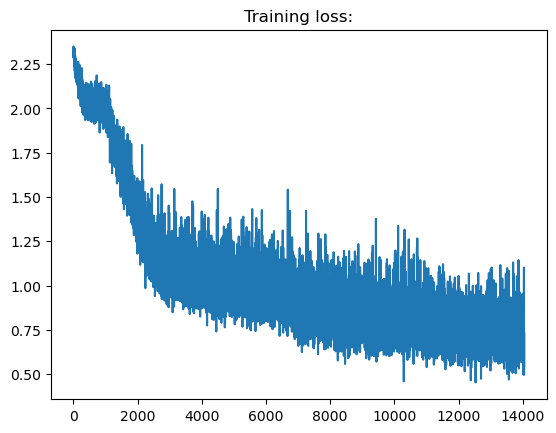

In [34]:
parameters, velocity = init_parameters(
    num_inputs = X_train.shape[0], 
    num_hidden_1 = 9, 
    num_hidden_2 = 3,
    num_outputs = num_classes,
)

trained_parameters = training_model(
    parameters, 
    velocity,
    batch_size = 128,                                     
    epoch = 30,
    learning_rate = 0.25,                                     
    beta = 0.5,                                     
    weight_decay_lambda = 0., 
)

### 3.2 Evaluate the performance of your model (<span style="color:green">0.5 points</span>)

In [35]:
def testing_model(X, parameters):
    # TODO: implement the forward propagation for testing step (0.5 point)
    # Hints: call forward_propagation() function and get the output A3
    outputs = forward_propagation(X, parameters)
    A3 = outputs[5]

    # Evaluate the performance of your model
    predictions = np.argmax(A3, axis=0)
    labels = np.argmax(Y_test, axis=0)
    
    print("Confusion matrix:\n{}".format(confusion_matrix(labels, predictions)))
    print("Testing accuracy: {}".format(accuracy_score(labels, predictions)))

In [38]:
testing_model(X_test, trained_parameters)

Confusion matrix:
[[769   2   0 108  10   1  93   0  17   0]
 [  5 927   0  47   8   0  12   0   1   0]
 [ 18   3   0  11 722   0 235   0  11   0]
 [ 74  54   0 803   6   0  61   0   2   0]
 [ 20  25   0  55 670   0 225   0   5   0]
 [  0   0   0   1   1 833   0  80  15  70]
 [212   4   0  78 284   0 391   0  31   0]
 [  0   0   0   0   0  37   0 880   0  83]
 [  8   1   0   3  17   5  25   5 935   1]
 [  0   1   0   1   0  22   0  46   1 929]]
Testing accuracy: 0.7137


## Part 4. Regularization and Hyperparameter Tuning (<span style="color:green">3 points</span>)

### Implement weight decay loss and backward propagation  (<span style="color:green">2 points</span>)

[Regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)) is a set of techniques in deep learning to prevent overfitting by adding a penalty term to the loss function, discouraging overly complex models, and promoting simpler, more generalizable ones. The loss function in regularization incorporates additional terms, like L1 or L2 regularization, which penalize large weights or complex models to prevent overfitting.

To implement weight decay regularization in our neural network, we can modify the loss function as follows:

$$
\begin{align}
L &= L_1 + L_2 \tag{30} \\
\\
L_1 &= {\rm cross\_entropy}(Y, A_3) \tag{31} \\
L_2 &= \frac{\lambda}{2} \left( ||W_1||_2^2 + ||W_2||_2^2 + ||W_3||_2^2 \right) \tag{32}
\end{align}
$$

Here $L_2$ denotes the weight decay loss, and $||\cdot||_2^2$ is the [L2 Regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)). For example, $||W_1||_2^2$ is calculated by:
$$
||W_1||_2^2 = \sum_{i=1}^{N}\sum_{j=1}^{M}{W_1^{(ij)}}^2
$$
which directly sums the squares of all elements in $W_1$.

In [39]:
def weight_decay_loss(parameters, lambd):
    """
    Args:
        parameters (tuple): Parameters in the model: W1, W2, W3
        lambd (float): The coefficient of weight decay
        m (float): The number of data samples in a mini batch
    """
    W1, W2, W3 = parameters
    

    
    # TODO: implement the weight decay loss in Eq. 32 (1 point)
    # Hints: use np.sum() and np.power()
    wdLoss = (lambd / 2) * (np.sum(np.power(W1, 2)) + np.sum(np.power(W2, 2)) + np.sum(np.power(W3, 2)))
    return wdLoss

In [40]:
np.random.seed(1)
parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)

loss = weight_decay_loss(parameters, lambd=0.0001)
print('loss:', loss)

loss: 0.35471489737579914


**<span style="color:green">Reference Results:</span>** <br>
loss: 0.35471489737579914

As here we use a new loss function $L$, we need to calculate the derivative $L$ with respect to $W_1, W_2, W_3$ for backward propagation again.

Take $W_1$ as an example, the derivative of $L$ with respect to $W_1$ is calculated by: 
$$
\begin{align}
d W_{1(new)} &= \frac{\partial L}{\partial W_1} = \frac{\partial L_1}{\partial W_1} + \frac{\partial L_2}{\partial W_1} = dW_1 + \lambda W_1 \tag{33}
\end{align}
$$

Here $dW_1$ is the previous derivative same as Eq. 23.

In [41]:
def backward_propagation_with_weight_decay(X, Y, parameters, outputs, lambd):
    """Method for forward propagation.
    Args:
        X (np.array): Input data
        Y (np.array): Ground truth of input data
        parameters (tuple): Parameters in the model: W1, W2, W3
        outputs (tuple): The forward propagation outputs: Z1, A1, Z2, A2, Z3, A3
        lambd (float): The coefficient of weight decay

    Returns:
        tuple: The computed gradients: dW1, dW2, dW3     
    """

    W1, W2, W3 = parameters
    dW1, dW2, dW3 = backward_propagation(X, Y, parameters, outputs)
    
    # TODO: calculate the new derivative of L with respect to W1, W2, and W3 based on Eq. 33 (1 point)
    dW3_new = dW3 + lambd * W3
    dW2_new = dW2 + lambd * W2
    dW1_new = dW1 + lambd * W1


    return dW1_new, dW2_new, dW3_new

In [42]:
np.random.seed(1)
X = np.random.randn(num_inputs, 2)
Y = np.random.randint(1, num_classes, (2, ))

parameters, _ = init_parameters(num_inputs, num_hidden_1, num_hidden_2, num_outputs)
outputs = forward_propagation(X, parameters)
dW1_new, dW2_new, dW3_new = backward_propagation_with_weight_decay(X, Y, parameters, outputs, lambd=0.0001)

print('\nExample results in dW3 (new):')
print(dW3_new[:, 0])

print('\nExample results in dW2 (new):')
print(dW2_new[:, 0])

print('\nExample results in dW1 (new):')
print(dW1_new[:, 0])


Example results in dW3 (new):
[-11.0768454  -11.18333839 -11.07941469 -11.15094559  -9.30678255
 -11.18963176 -11.1838994  -11.18909476 -10.89788101 -11.14890796]

Example results in dW2 (new):
[ 9.68498668 -5.58462452  4.69335025]

Example results in dW1 (new):
[ 1.42425268e-02 -6.39850968e-01 -1.87264211e-05 -2.81056313e-05
  2.11108273e-04  1.11403812e-04 -3.10541295e-05  4.55282195e-05
  4.47521792e-03]


**<span style="color:green">Reference Results:</span>** <br>
Example results in dW3 (new):<br>
[-11.0768454  -11.18333839 -11.07941469 -11.15094559  -9.30678255<br>
 -11.18963176 -11.1838994  -11.18909476 -10.89788101 -11.14890796]<br>

Example results in dW2 (new):<br>
[ 9.68498668 -5.58462452  4.69335025]<br>

Example results in dW1 (new):<br>
[ 1.42425268e-02 -6.39850968e-01 -1.87264211e-05 -2.81056313e-05<br>
  2.11108273e-04  1.11403812e-04 -3.10541295e-05  4.55282195e-05<br>
  4.47521792e-03]<br>

### Hyperparameter Tuning (<span style="color:green">1 points</span>)

[Hyperparameter Tuning](https://en.wikipedia.org/wiki/Hyperparameter_optimization) is an effective way to optimize the performance of neural network models in machine learning. 

For our neural network, we can adjust many hyper-parameters, such as learning rate, batch size, weight decay coefficient, training epochs, and the model architecture choices (number of neruons in hidden layers).

Start training the model:
Number of training samples: 60000
Number of batchs: 468
[Epoch][Iterations]:[0/30][200/468], loss: 2.3615724666632585
[Epoch][Iterations]:[0/30][400/468], loss: 2.126486268649112
=> Epoch 0, elapsed time: 0.48 seconds
[Epoch][Iterations]:[1/30][200/468], loss: 1.836170313513205
[Epoch][Iterations]:[1/30][400/468], loss: 1.985328274715946
=> Epoch 1, elapsed time: 0.57 seconds
[Epoch][Iterations]:[2/30][200/468], loss: 1.8003900462220717
[Epoch][Iterations]:[2/30][400/468], loss: 1.4882664976856774
=> Epoch 2, elapsed time: 0.62 seconds
[Epoch][Iterations]:[3/30][200/468], loss: 1.5238063256767558
[Epoch][Iterations]:[3/30][400/468], loss: 1.3405581914672469
=> Epoch 3, elapsed time: 0.64 seconds
[Epoch][Iterations]:[4/30][200/468], loss: 1.2894509312884157
[Epoch][Iterations]:[4/30][400/468], loss: 1.3244603475055667
=> Epoch 4, elapsed time: 0.59 seconds
[Epoch][Iterations]:[5/30][200/468], loss: 1.148950987838569
[Epoch][Iterations]:[5/30][400/468], loss: 1.

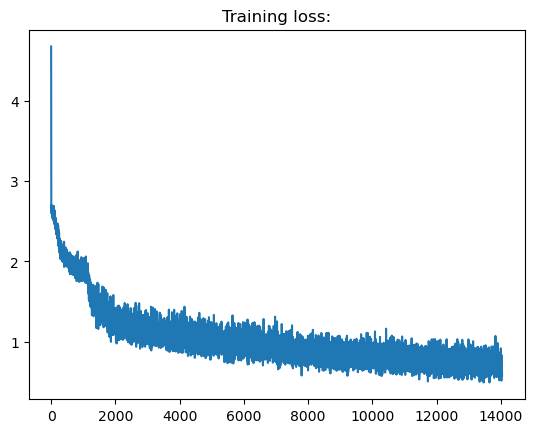

In [59]:
# TODO: adjust the values of hyper-parameters below and try to improve the testing accuracy. (1 point)
# Hints: try to adjust 'num_hidden_2', 'weight_decay_lambda' or other hyper-parameters

parameters, velocity = init_parameters(
    num_inputs = X_train.shape[0], 
    num_hidden_1 = 9, 
   num_hidden_2 = 5,
    num_outputs=num_classes
)

trained_parameters = training_model(
    parameters, 
    velocity,
    batch_size = 128,                                     
    epoch = 30,
    learning_rate = 0.25,                                     
    beta = 0.5,                                     
    weight_decay_lambda = 0.0001, 
)

In [60]:
testing_model(X_test, trained_parameters)

Confusion matrix:
[[844   6  11  39   3   0  77   0  20   0]
 [ 10 949   3  26   6   0   3   0   3   0]
 [ 18   5 694   7 193   0  70   0  12   1]
 [ 66  17   7 806  34   0  57   0  13   0]
 [  0   2 117  38 713   0 125   0   5   0]
 [  0   0   0   3   0 861   0  55  16  65]
 [217   4 137  28 131   0 457   0  26   0]
 [  0   0   0   0   0  42   0 886   0  72]
 [  2   1   1   8   1  11  47   3 924   2]
 [  0   0   0   1   0  13   0  45   2 939]]
Testing accuracy: 0.8073


**<span style="color:green">Reference Results:</span>** <br>
Testing accuracy: 0.8000<br>

(You can get this grade point if your accuracy reach 0.8 or better)